In [1]:
import gensim
import nltk
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from collections import Counter
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from raceplotly.plots import barplot
from sklearn.feature_extraction.text import CountVectorizer

## First time users should uncomment the below two lines
    
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('omw-1.4')
# nltk.download('stopwords')

First, the data is read into a dataframe:

In [2]:
### Get the data

df = pd.read_csv("../data/blogs_with_analytics.csv", sep="\t")
# df
df.dropna(subset=["text"], inplace=True)
df.head(5)

,index,url,title,time,category,description,text,introduction,author,author_job_title,...,exit%,semantic neg score,semantic neu score,semantic pos score,semantic compound score,average_sentence_length,dale_chall,flesch,average_stopword,text_length
0,0,blog/futustories-six-reasons-pasi-left-and-cam...,FutuStories - Six reasons Pasi left – and came...,2022-09-16,Culture,"For Senior Cloud Consultant Pasi, a change can...",1. I need awesome people around me…\r\nI’d say...,"For Cloud Archtitect Pasi, a change can be as ...",Pia Hämäri,"Marketing Lead, Finland",...,0.527473,0.053,0.760,0.187,0.9990,17.560976,6.88,75.84,8.707317,720
1,1,blog/foresight-methods-and-strategic-planning,Foresight methods and strategic planning in bu...,2022-09-13,Strategy,Foresight methods and strategic planning lead ...,This is where foresight methods and strategic ...,"If the past few years have taught us anything,...",Annina Antinranta,Principal Designer - Emerging Business,...,0.272727,0.020,0.849,0.131,0.9985,15.950820,7.99,45.05,7.166667,973
2,2,blog/uncertainty-in-business-volatile-market,Uncertainty in business and how to deal with it,2022-09-12,Opinion,"Future uncertainty, how to deal with uncertain...",The silver lining to all this doom and gloom i...,"Looming global threats like war, recession and...",Andreas Lindqvist,"Business Director, Futurice",...,0.571429,0.193,0.704,0.103,-0.7525,35.500000,11.40,43.90,17.000000,71
3,3,blog/futustories-emma-leena-heikkinens-story,FutuStories – Emma-Leena Heikkinen’s story,2022-09-01,Culture,To be leader is not naturally given. Emma-Leen...,What does your role involve?\r\nI’m a client l...,"Human connections, honesty and trust are impor...",Pia Hämäri,"Marketing Lead, Finland",...,0.672222,0.031,0.789,0.180,0.9993,19.195652,7.52,68.50,9.847826,883
4,4,blog/safe-route-uncertain-times,The Safe Route project and how it relates to d...,2022-08-26,Opinion,Good quality data used in the right way is at ...,Safe Route uses data from STRADA - a database ...,Safe Route was conceived as a new way to think...,Sonja Lakner,"Managing Director, Sweden",...,0.609524,0.065,0.711,0.224,0.9995,27.709677,9.07,39.20,14.259259,859


# Graphs of the basic statistics
## Average sentence length, with the problematics results removed

(array([  9.,  20.,  84., 220., 253., 155.,  27.,  13.,   3.,   1.]),
 array([ 3.5,  6.7,  9.9, 13.1, 16.3, 19.5, 22.7, 25.9, 29.1, 32.3, 35.5]),
 <BarContainer object of 10 artists>)

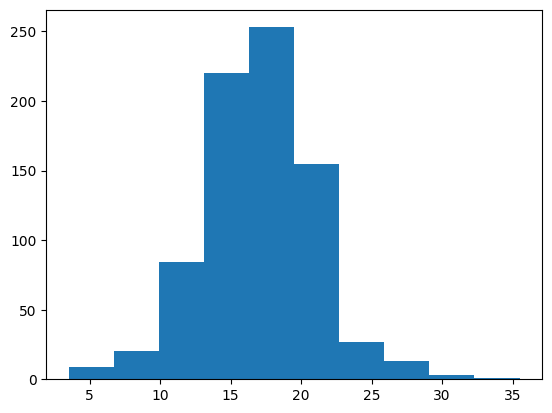

In [177]:
plt.hist(df[df["average_sentence_length"] < 300 ]["average_sentence_length"])

## Readability scores

(array([  3.,  10.,  42., 140., 268., 231.,  88.,   2.,   0.,   1.]),
 array([ 11.07,  20.63,  30.19,  39.75,  49.31,  58.87,  68.43,  77.99,
         87.55,  97.11, 106.67]),
 <BarContainer object of 10 artists>)

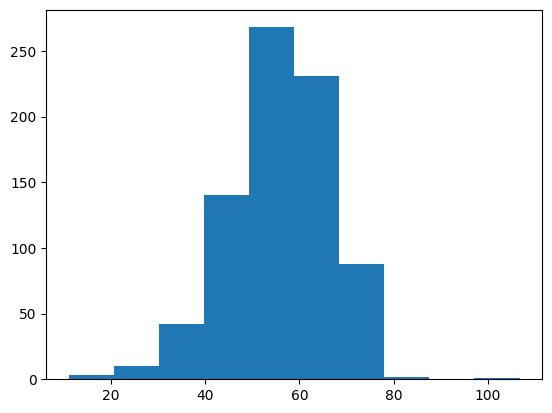

In [178]:
plt.hist(df[df["average_sentence_length"] < 300 ]["flesch"])

(array([ 34., 294., 346.,  82.,  19.,   6.,   2.,   0.,   0.,   2.]),
 array([ 6.24,  7.24,  8.24,  9.24, 10.24, 11.24, 12.24, 13.24, 14.24,
        15.24, 16.24]),
 <BarContainer object of 10 artists>)

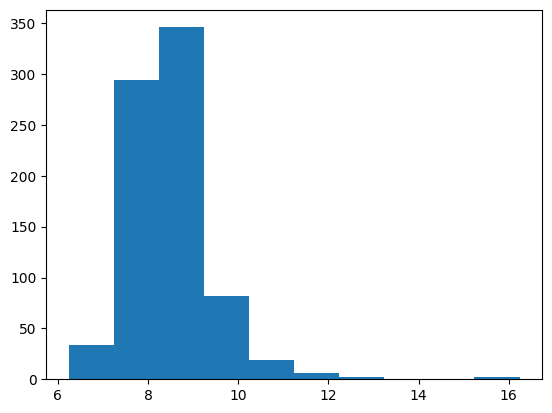

In [179]:
plt.hist(df[df["average_sentence_length"] < 300 ]["dale_chall"])

## Average stopword per sentence

(array([  4.,   1.,  25., 129., 317., 200.,  83.,  18.,   5.,   3.]),
 array([ 0. ,  1.7,  3.4,  5.1,  6.8,  8.5, 10.2, 11.9, 13.6, 15.3, 17. ]),
 <BarContainer object of 10 artists>)

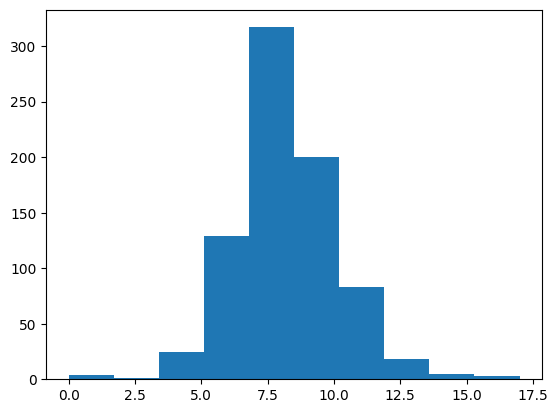

In [180]:
plt.hist(df["average_stopword"])

# Some additional statistics
These are statistics that might not be able to fit into the csv file

## Most common word in a period of time
In this part, there are some rows that the date is `nan`. For those rows, I just remove them completely

So now we can start doing the real work. But first, let's try to split the data into different month interval 

In [3]:
### Helper functions 
# Generate interval based on a date range
def get_date_interval(startDate, endDate, month_interval):
    s = pd.date_range(start=startDate, end=endDate, freq=str(month_interval)+"MS", inclusive='left')
    e = (s[1:]-pd.to_timedelta(1, unit='D'))
    return list(zip(s.strftime('%Y-%m-%d').tolist(), e.strftime('%Y-%m-%d').tolist() + [endDate]))

# Preprocessing: tokenization, stopwords removal, lemmatization, and stemming
stemmer = SnowballStemmer("english")
def lemmatize_stem(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text, min_len=3):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stem(token))
    return result


def cooking_2(df_main, period=1):
    ## Preprocessing and generating the lists that we will need
    df_ = df_main.copy()
    df_["time"] = pd.to_datetime(df_["time"])
    df_ = df_[df_["time"].notna()]   # Filling the nan rows of the time in dataframe
    df_ = df_.sort_values(by='time',ascending=True)  # Sort the rows by the date
    
    # Get all available date interval
    date_intervals = get_date_interval(df_["time"].iloc[0], df_["time"].iloc[-1], period)
    date_intervals[-1] = (date_intervals[-1][0], date_intervals[-1][1].strftime('%Y-%m-%d'))

    ## The main loop:
    blog_in_range = {}   # The result list
    # Since the helper function does not generate the interval starting from the middle of the month, I have to compromise by manually adding them into the temp list
    temp_list = [df_.iloc[0]["text"], df_.iloc[1]["text"]] 
    index = 0
    i=2   # Thus, we are starting from index 2
    total_blogs = 2

    while i < len(df_["time"]):
        current_row = df_.iloc[i]   # Get the current row of the dataframe
        current_interval = date_intervals[index]  # What is the current interval that we are considering?

        # If the date is in the current interval, add the row to the temp list
        if(datetime.strptime(current_interval[0], '%Y-%m-%d') <= current_row["time"] <= datetime.strptime(current_interval[1], '%Y-%m-%d')):  
            temp_list.append(current_row["text"])
            total_blogs += 1
            i += 1
    
        # If the date is not in the interval, it means that we are going to the next interval, adding the temp list into the result and increment the index
        else:             
            blog_in_range[current_interval] = (temp_list, total_blogs)
            temp_list = []
            total_blogs = 0
            index += 1
    blog_in_range[date_intervals[-1]] = (temp_list, total_blogs)

    ## Final processing to get the results
    blog_in_range = dict(filter(lambda pair: len(pair[1][0]) != 0, blog_in_range.items()))         # Remove the intervals that do not contain any texts
    blog_in_range = { interval[1]:(Counter(preprocess(" ".join(blogs))), count) for (interval, (blogs, count)) in blog_in_range.items() } # Combined all the text in the intervals
    for (interval, (counter, total)) in blog_in_range.items():
        for item, count in counter.items():
            counter[item] /= total
        blog_in_range[interval] = counter
    return blog_in_range

test = cooking_2(df)

In [182]:
pd.DataFrame(test)

,2010-03-31,2010-05-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,...,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-18
search,8.00,NaN,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,...,NaN,0.166667,0.142857,0.125,0.25,0.428571,0.25,NaN,NaN,NaN
word,0.25,0.5,NaN,NaN,NaN,0.333333,NaN,NaN,NaN,NaN,...,NaN,0.666667,0.142857,0.125,NaN,0.285714,NaN,NaN,0.25,NaN
sweet,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.125,NaN,0.714286,NaN,NaN,NaN,NaN
innoc,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
harmless,0.25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
wildlif,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN
backyard,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN
fonder,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.25,NaN
humanis,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


## Word trend throughout the months

Here, I create a new function to return a trend graph automatically. The function requires the dataframe, the period length (which is default to 1), the number of bar the users want to appear each time (which is default to 7), and the speed of the graph (defaulted to 500).

In [183]:
def huffing_rpl_2(df, period=1, nbars=10, plength=1000):
    _trend = pd.DataFrame(cooking_2(df, period)).fillna(0).T
    _trend = _trend.melt(ignore_index=False).reset_index().rename(columns={"index":"date"})
    myplot = barplot(_trend, item_column="variable", value_column="value", time_column="date", top_entries=nbars)
    fig = myplot.plot(title="Word popularity by {:d}-month period".format(period), item_label="Words", value_label="Count", time_label="Time: ", frame_duration=plength)
    fig.update_layout(
                font={'size':17},
                plot_bgcolor='black',
                height=600
                )
    fig.write_html("../data/figs/{:d}months.html".format(period))
    return

# huffing_rpl_2(df, period=1)
# huffing_rpl_2(df, period=3)
# huffing_rpl_2(df, period=6)
# huffing_rpl_2(df, period=12)


# Format 
`{ date : ([(word, count)], total_text) }`

In [4]:
def get_blog_in_range(df_main, period=1):
     ## Preprocessing and generating the lists that we will need
    df_ = df_main.copy()
    df_["time"] = pd.to_datetime(df_["time"])
    df_ = df_[df_["time"].notna()]   # Filling the nan rows of the time in dataframe
    df_ = df_.sort_values(by='time',ascending=True)  # Sort the rows by the date
    
    # Get all available date interval
    date_intervals = get_date_interval(df_["time"].iloc[0], df_["time"].iloc[-1], period)
    date_intervals[-1] = (date_intervals[-1][0], date_intervals[-1][1].strftime('%Y-%m-%d'))

    ## The main loop:
    blog_in_range = {}   # The result list
    # Since the helper function does not generate the interval starting from the middle of the month, I have to compromise by manually adding them into the temp list
    temp_list = [df_.iloc[0]["text"], df_.iloc[1]["text"]] 
    index = 0
    i=2   # Thus, we are starting from index 2
    total_blogs = 2

    while i < len(df_["time"]):
        current_row = df_.iloc[i]   # Get the current row of the dataframe
        current_interval = date_intervals[index]  # What is the current interval that we are considering?

        # If the date is in the current interval, add the row to the temp list
        if(datetime.strptime(current_interval[0], '%Y-%m-%d') <= current_row["time"] <= datetime.strptime(current_interval[1], '%Y-%m-%d')):  
            temp_list.append(current_row["text"])
            total_blogs += 1
            i += 1
    
        # If the date is not in the interval, it means that we are going to the next interval, adding the temp list into the result and increment the index
        else:             
            blog_in_range[current_interval] = (temp_list, total_blogs)
            temp_list = []
            total_blogs = 0
            index += 1
    blog_in_range[date_intervals[-1]] = (temp_list, total_blogs)
    blog_in_range = dict(filter(lambda pair: len(pair[1][0]) != 0, blog_in_range.items()))         # Remove the intervals that do not contain any texts
    return { interval[1]:texts for (interval, texts) in blog_in_range.items() }
    

def grillin(df_main, period=1, ngram_range=(2, 2)):
    blog_in_range = get_blog_in_range(df_main, period)
    for (interval, (text_list, total_text)) in blog_in_range.items():
        combined_text = " ".join(text_list)
        vectorizer = CountVectorizer(stop_words='english', ngram_range=ngram_range)
        matrix = vectorizer.fit_transform([combined_text])
        token_with_count = list(zip(vectorizer.get_feature_names_out(), matrix.toarray()[0]))
        token_with_count = list(filter(lambda pair: not pair[0].isnumeric(), token_with_count))
        blog_in_range[interval] = { word:counts/total_text for (word, counts) in token_with_count }
    return blog_in_range

# test2 = grillin(df)

In [9]:
# test2= pd.DataFrame(test2).fillna(0)

In [15]:
# test2.iloc[1000:1020, :]

,2010-03-31,2010-05-31,2010-09-30,2010-10-31,2010-11-30,2010-12-31,2011-02-28,2011-03-31,2011-04-30,2011-05-31,...,2022-01-31,2022-02-28,2022-03-31,2022-04-30,2022-05-31,2022-06-30,2022-07-31,2022-08-31,2022-09-30,2022-10-18
guy happens,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
guy j2ee,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
guy meeting,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
guy says,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
half hours,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hand war,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
happens like,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
harder internal,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hate ruby,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hear customer,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [224]:
def huffing_rpl_3(df, period=1, nbars=10, plength=1000):
    _trend = pd.DataFrame(grillin(df, period)).fillna(0).T
    _trend = _trend.melt(ignore_index=False, value_name='frequency_count').reset_index().rename(columns={"index":"date"})
    myplot = barplot(_trend, item_column="variable", value_column="frequency_count", time_column="date", top_entries=nbars)
    fig = myplot.plot(title="Word popularity by {:d}-month period".format(period), item_label="Words", value_label="Count", time_label="Time: ", frame_duration=plength)
    fig.update_layout(
                font={'size':17},
                plot_bgcolor='black',
                height=600
                )
    fig.write_html("../data/figs/{:d}months_bigrams.html".format(period))
    return

huffing_rpl_3(df, period=1)
huffing_rpl_3(df, period=3)
huffing_rpl_3(df, period=6)
huffing_rpl_3(df, period=12)